# Part 3 - machine learning - modeling and evaluation

In [1]:
import pandas as pd
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# scoring 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy.stats import shapiro

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()      
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('pt3_df.csv')
df.head()

,RBI,R,H,IBB,adj_salary
0,0.0,1,2,0.0,528240.0
1,83.0,82,157,2.0,2301147.0
2,242.0,273,523,11.0,11970434.0
3,34.0,65,86,2.0,528240.0
4,79.0,97,212,1.0,926963.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RBI         2498 non-null   float64
 1   R           2498 non-null   int64  
 2   H           2498 non-null   int64  
 3   IBB         2498 non-null   float64
 4   adj_salary  2498 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 97.7 KB


In [4]:
# Splitting data
X = df.loc[:,:'IBB'].copy()
y = df.adj_salary.copy()

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

- Ready for machine learning

## Simple Linear Regression
- I'll start with a simple regression model, which attempts to predict earnings based on RBIs alone

In [5]:
simp_lr = LinearRegression()

In [6]:
simp_lr.fit(X_train[['RBI']], y_train)

LinearRegression()

In [7]:
print('Train score:', simp_lr.score(X_train[['RBI']], y_train))
print('Test score:', simp_lr.score(X_test[['RBI']], y_test))

Train score: 0.8232100678368737
Test score: 0.7749300733647874


> Scores are based on the coefficient of determination, also known as the R-squared value, which is a statistical measure that represents the proportion of variance in one variable that is predictable from the other variable(s) in a linear regression model. It ranges from 0 to 1, with 0 indicating that the model does not explain any variability in the response variable and 1 indicating that the model explains all the variability in the response variable.

The proportion of the variance in the response variable that can be explained by the predictor variables in the regression model.

- The scores aren't bad but the model is slightly overfit as the train score exceeds the test score

In [8]:
intercept = simp_lr.intercept_
coefficient = simp_lr.coef_
print('Formula: Earnings = {0:0.2f} + ({1:0.2f} * RBI)'.format(intercept, coefficient[0]))

Formula: Earnings = -9417388.98 + (150013.15 * RBI)


- With the simple linear formula, players need to hit 63 RBIs to break even

In [9]:
predictions = simp_lr.predict(X_test[['RBI']])

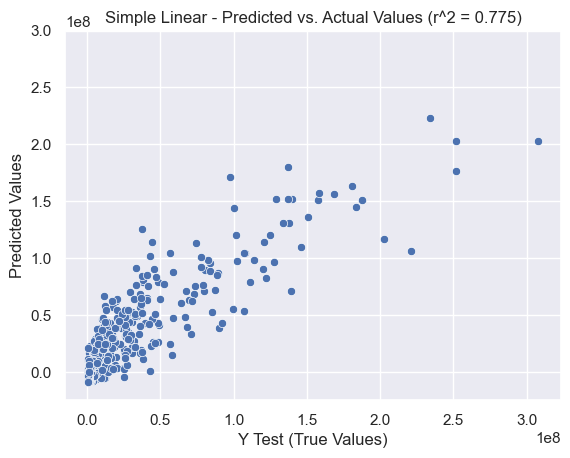

In [10]:
sns.scatterplot(y_test, predictions)
plt.ylim(-25000000, 300000000)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('Simple Linear - Predicted vs. Actual Values (r^2 = {0:0.3f})'.format(r2_score(y_test, predictions), (0, 1)))
plt.show()

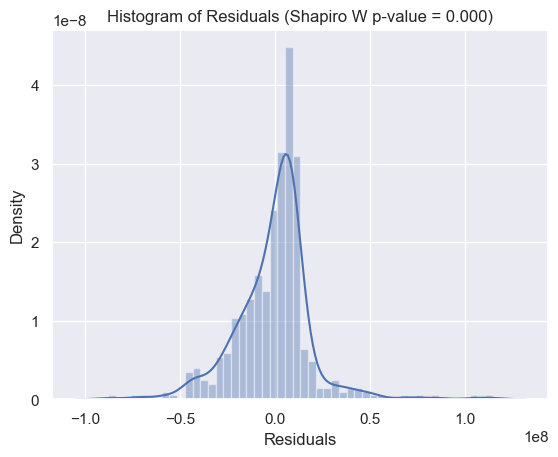

In [11]:
sns.distplot((y_test - predictions), bins = 50)

plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals (Shapiro W p-value = {0:0.3f})'.format(shapiro(y_test - predictions)[1]))

plt.show()

In [12]:
metrics_df = pd.DataFrame({'Metric': ['MAE (Mean absolute error)',
                                      'R-Squared'],

                          'Value': [metrics.mean_absolute_error(y_test, predictions),
                                    metrics.explained_variance_score(y_test, predictions)]}).round(3)

print(metrics_df)

                      Metric         Value
0  MAE (Mean absolute error)  1.370225e+07
1                  R-Squared  7.750000e-01


# Multiple Linear Regression
- The multiple linear regression model utilizes all dependent variables

In [13]:
mlr = LinearRegression()

In [14]:
mlr.fit(X_train, y_train)

LinearRegression()

In [15]:
print('Train score:', mlr.score(X_train, y_train))
print('Test score:', mlr.score(X_test, y_test))

Train score: 0.8603805576304279
Test score: 0.8107137036439122


- The scores both improved but overfitting remains an issue

In [16]:
predictions = mlr.predict(X_test)

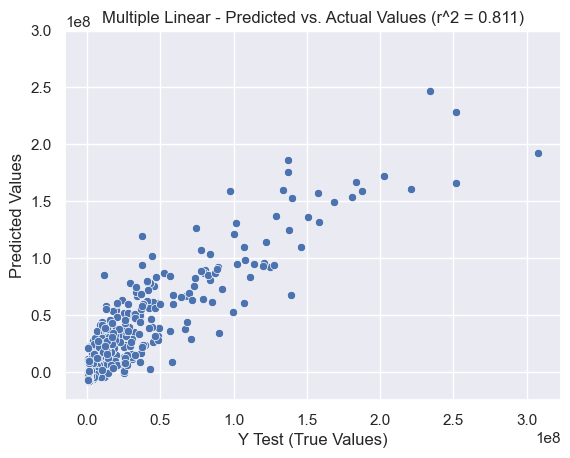

In [17]:
sns.scatterplot(y_test, predictions)
plt.ylim(-25000000, 300000000)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('Multiple Linear - Predicted vs. Actual Values (r^2 = {0:0.3f})'.format(r2_score(y_test, predictions), (0, 1)))
plt.show()

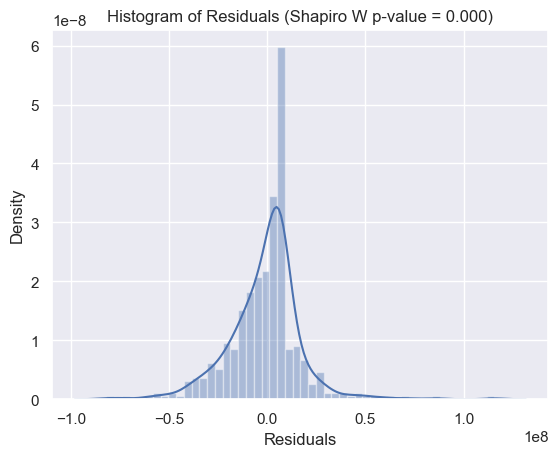

In [18]:
sns.distplot((y_test - predictions), bins = 50)

plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals (Shapiro W p-value = {0:0.3f})'.format(shapiro(y_test - predictions)[1]))

plt.show()

In [19]:
metrics_df = pd.DataFrame({'Metric': ['MAE (Mean absolute error)',
                                      'R-Squared'],

                          'Value': [metrics.mean_absolute_error(y_test, predictions),
                                    metrics.explained_variance_score(y_test, predictions)]}).round(3)

print(metrics_df)

                      Metric         Value
0  MAE (Mean absolute error)  1.265503e+07
1                  R-Squared  8.110000e-01


## KNN Regressor

In [20]:
cols = df.columns
target_col = 'adj_salary'
feat_cols = [c for c in cols if c != target_col]

# converting features to array type
array = df.values

X = array[:, :-1]
y = array[:, -1]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
knn = KNeighborsRegressor(n_neighbors=3, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=3)

In [23]:
print('Train score:', knn.score(X_train, y_train))
print('Test score:', knn.score(X_test, y_test))

Train score: 0.9194769769880577
Test score: 0.8024975154632612


In [24]:
# gather the predictations that our model made for our test set
preds = knn.predict(X_test)
differs = y_test - preds

# display the actuals and predictions for the test set
print('First 10 actuals for test data set')
print(y_test[:10])
print('First 10 predictions for test data set')
print(preds[:10])
print('First 10 differences between the two sets')
print(differs[:10])

First 10 actuals for test data set
[2.94163630e+07 4.85443800e+07 5.07440000e+05 1.15176960e+07
 3.25333200e+06 9.90239200e+06 7.28381500e+06 1.89586000e+06
 9.26142000e+05 1.39206304e+08]
First 10 predictions for test data set
[67303775.         42907705.          1892686.         33573653.
  1047714.66666667 48655001.          2899489.66666667  5411629.66666667
   834381.66666667 63524947.33333334]
First 10 differences between the two sets
[-37887412.           5636675.          -1385246.
 -22055957.           2205617.33333333 -38752609.
   4384325.33333333  -3515769.66666667     91760.33333333
  75681356.66666666]


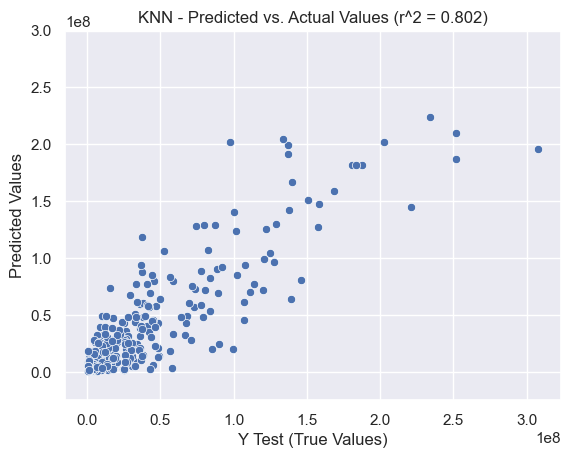

In [25]:
sns.scatterplot(y_test, preds)
plt.ylim(-25000000, 300000000)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('KNN - Predicted vs. Actual Values (r^2 = {0:0.3f})'.format(r2_score(y_test, preds), (0, 1)))

plt.show()

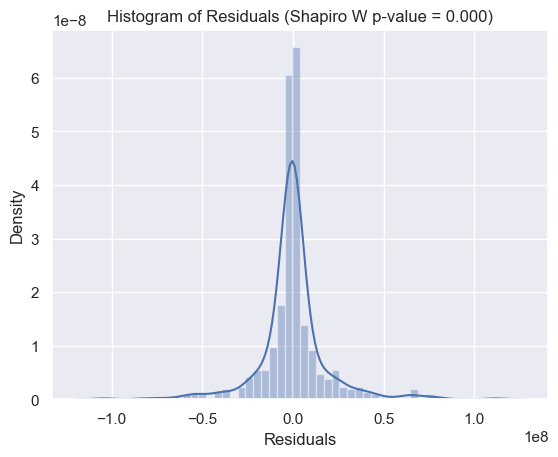

In [26]:
sns.distplot((y_test - preds), bins = 50)

plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals (Shapiro W p-value = {0:0.3f})'.format(shapiro(y_test - predictions)[1]))

plt.show()

In [27]:
metrics_df = pd.DataFrame({'Metric': ['MAE (Mean absolute error)',
                                      'R-Squared'],

                          'Value': [metrics.mean_absolute_error(y_test, preds),
                                    metrics.explained_variance_score(y_test, preds)]}).round(3)

print(metrics_df)

                      Metric         Value
0  MAE (Mean absolute error)  1.009643e+07
1                  R-Squared  8.030000e-01


In [28]:
scores = []
print(f'Features: {feat_cols} \nTarget: {target_col}')

# remember the ending number for range is not inclusive
for k in range(2, 30):
    # output to let us know where we are
    print(f'Evaluating {k} clusters')
    
    # n_jobs=-1 will use all processors on your system
    model = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Features: ['RBI', 'R', 'H', 'IBB'] 
Target: adj_salary
Evaluating 2 clusters
Evaluating 3 clusters
Evaluating 4 clusters
Evaluating 5 clusters
Evaluating 6 clusters
Evaluating 7 clusters
Evaluating 8 clusters
Evaluating 9 clusters
Evaluating 10 clusters
Evaluating 11 clusters
Evaluating 12 clusters
Evaluating 13 clusters
Evaluating 14 clusters
Evaluating 15 clusters
Evaluating 16 clusters
Evaluating 17 clusters
Evaluating 18 clusters
Evaluating 19 clusters
Evaluating 20 clusters
Evaluating 21 clusters
Evaluating 22 clusters
Evaluating 23 clusters
Evaluating 24 clusters
Evaluating 25 clusters
Evaluating 26 clusters
Evaluating 27 clusters
Evaluating 28 clusters
Evaluating 29 clusters



Max R^2 = 83.21999689569945%


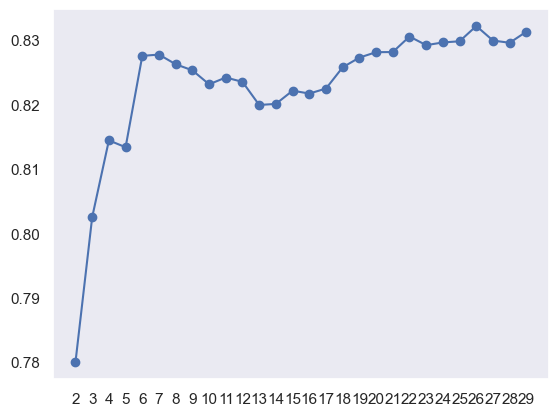

In [29]:
# display the resutls
plt.plot(range(2, 30), scores)
plt.scatter(range(2, 30), scores)
plt.grid()
_ =plt.xticks(range(2, 30))

print(f'\nMax R^2 = {(max(scores)*100)}%')

In [30]:
# define and fit our model
model = KNeighborsRegressor(n_neighbors=26, n_jobs=-1)
model.fit(X_train, y_train)

# gather the predictations that our model made for our test set
preds = model.predict(X_test)
differs = y_test - preds

# display the actuals and predictions for the test set
print('First 10 actuals for test data set')
print(y_test[:10])
print('First 10 predictions for test data set')
print(preds[:10])
print('First 10 differences between the two sets:')
print(differs[:10])

First 10 actuals for test data set
[2.94163630e+07 4.85443800e+07 5.07440000e+05 1.15176960e+07
 3.25333200e+06 9.90239200e+06 7.28381500e+06 1.89586000e+06
 9.26142000e+05 1.39206304e+08]
First 10 predictions for test data set
[51910205.07692308 60793681.15384615  1558232.46153846 36357163.73076923
  2732240.34615385 31844437.53846154 10893096.96153846  3275773.34615385
   907290.34615385 39237901.53846154]
First 10 differences between the two sets:
[-2.24938421e+07 -1.22493012e+07 -1.05079246e+06 -2.48394677e+07
  5.21091654e+05 -2.19420455e+07 -3.60928196e+06 -1.37991335e+06
  1.88516538e+04  9.99684025e+07]


In [31]:
print('Train score:', model.score(X_train, y_train))
print('Test score:', model.score(X_test, y_test))

Train score: 0.8666071676933836
Test score: 0.8321999689569946


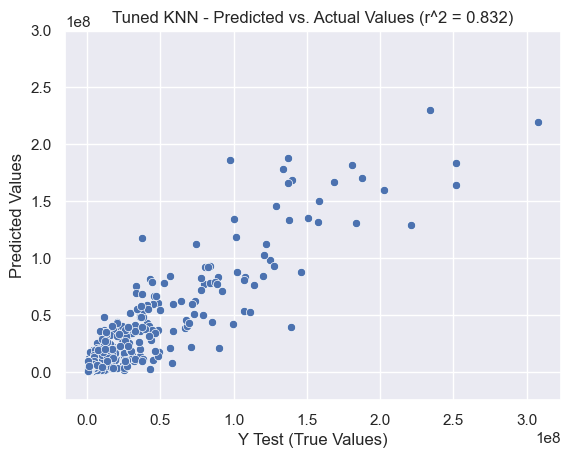

In [32]:
sns.scatterplot(y_test, preds)
plt.ylim(-25000000, 300000000)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('Tuned KNN - Predicted vs. Actual Values (r^2 = {0:0.3f})'.format(r2_score(y_test, preds), (0, 1)))

plt.show()

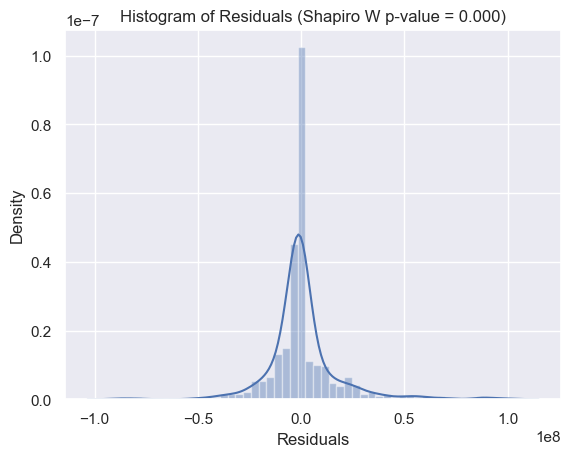

In [33]:
sns.distplot((y_test - preds), bins = 50)

plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals (Shapiro W p-value = {0:0.3f})'.format(shapiro(y_test - predictions)[1]))

plt.show()

In [34]:
metrics_df = pd.DataFrame({'Metric': ['MAE (Mean absolute error)',
                                      'R-Squared'],

                          'Value': [metrics.mean_absolute_error(y_test, preds),
                                    metrics.explained_variance_score(y_test, preds)]}).round(3)

print(metrics_df)

                      Metric        Value
0  MAE (Mean absolute error)  9392546.663
1                  R-Squared        0.832


## K-Fold Cross-Validation (R^2 scoring)

In [35]:
# regression models, no scaling
models = []
models.append(('Linear Reg', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('LassoCV', LassoCV()))
models.append(('RidgeCV', RidgeCV()))
models.append(('Elastic Net', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))

In [36]:
seed = 42
num_folds = 5
scoring = 'r2'

In [37]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Linear Reg: 0.854264 (0.009861)
Lasso: 0.854264 (0.009861)
LassoCV: 0.855563 (0.014923)
RidgeCV: 0.854264 (0.009861)
Elastic Net: 0.854294 (0.009881)
KNN: 0.864552 (0.021613)


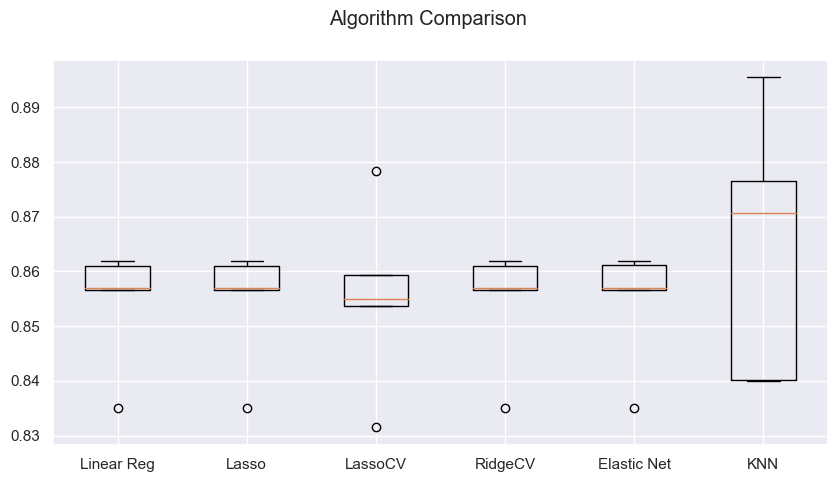

In [38]:
# boxplot comparison
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [39]:
# ensemble models, no scaling
models = []
models.append(('AB', AdaBoostRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators=10)))
models.append(('ET', ExtraTreesRegressor(n_estimators=10)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.835141 (0.020570)
GBM: 0.878724 (0.020283)
RF: 0.864021 (0.018551)
ET: 0.862810 (0.020915)


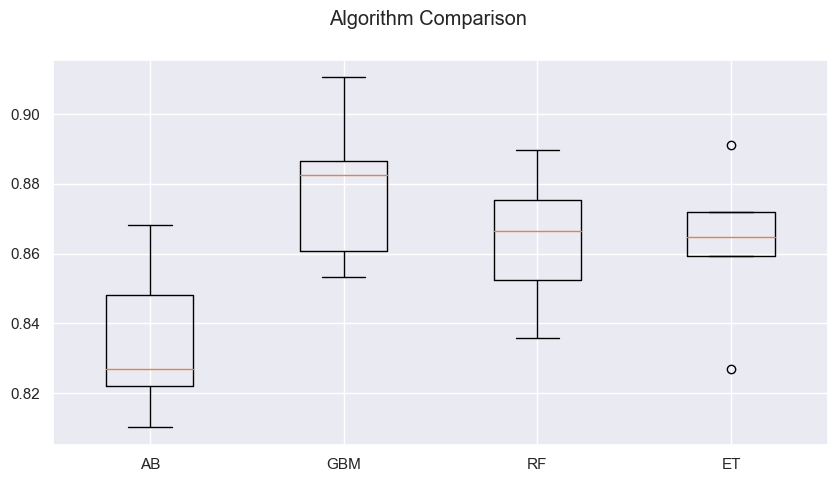

In [40]:
# boxplot comparison
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [41]:
# regression models, scaled data
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('Linear Reg', LinearRegression())])))
pipelines.append(('ScaledLasso', Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso())])))
pipelines.append(('ScaledLassoCV', Pipeline([('Scaler', StandardScaler()),('LassoCV', LassoCV())])))
pipelines.append(('ScaledRidgeCV', Pipeline([('Scaler', StandardScaler()),('RidgeCV', RidgeCV())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('Elastic Net', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.854264 (0.009861)
ScaledLasso: 0.854264 (0.009861)
ScaledLassoCV: 0.852015 (0.016730)
ScaledRidgeCV: 0.853827 (0.012544)
ScaledEN: 0.837966 (0.032032)
ScaledKNN: 0.854588 (0.020721)


<Figure size 640x480 with 0 Axes>

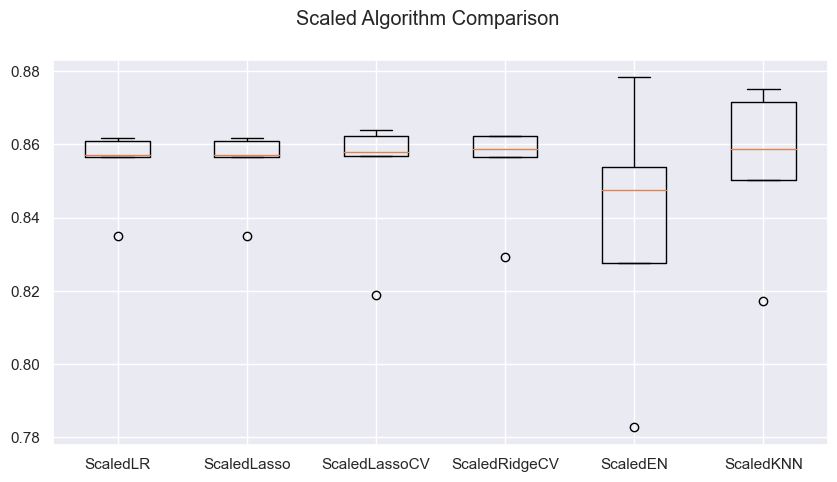

In [42]:
# boxplot comparison
fig = plt.figure()
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [43]:
# ensemble models, scaled data
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: 0.828781 (0.004521)
ScaledGBM: 0.877351 (0.018396)
ScaledRF: 0.862894 (0.022387)
ScaledET: 0.861302 (0.013988)


<Figure size 640x480 with 0 Axes>

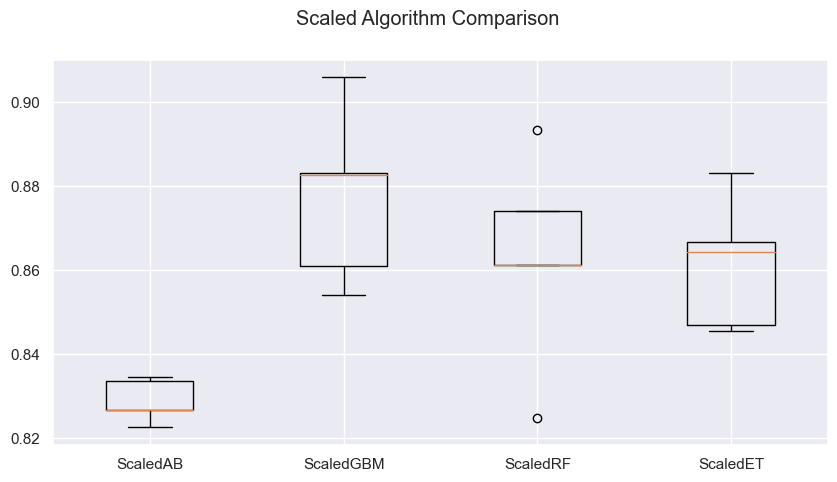

In [44]:
# boxplot comparison
fig = plt.figure()
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## KNN Crossfold (Negative MAE scoring)

In [45]:
scoring = 'neg_mean_absolute_error'

In [46]:
# regression models, unscaled data
models = []
models.append(('Linear Reg', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('LassoCV', LassoCV()))
models.append(('RidgeCV', RidgeCV()))
models.append(('Elastic Net', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Linear Reg: -12429112.666045 (455774.767323)
Lasso: -12429112.671292 (455774.768933)
LassoCV: -12641936.661435 (527661.773733)
RidgeCV: -12429123.087777 (455775.387880)
Elastic Net: -12429940.232581 (455792.193127)
KNN: -10095452.302948 (1083136.859223)


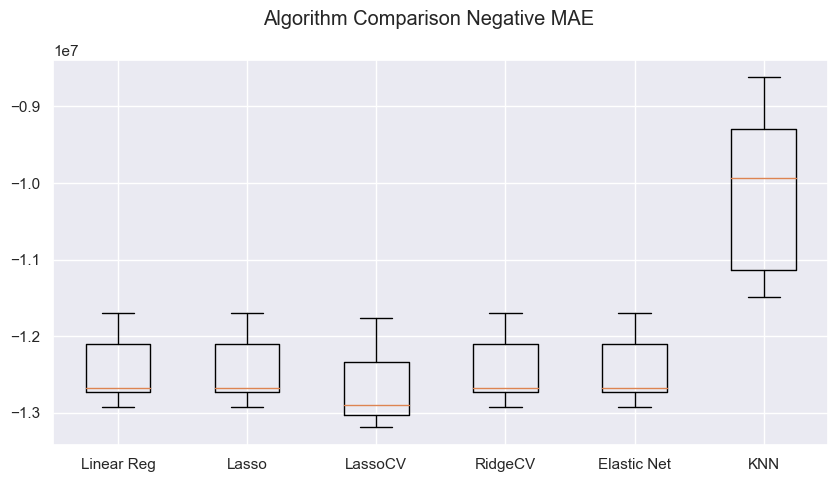

In [47]:
# algorithm performance
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Algorithm Comparison Negative MAE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [48]:
# ensemble models, unscaled data
models = []
models.append(('AB', AdaBoostRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators=10)))
models.append(('ET', ExtraTreesRegressor(n_estimators=10)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: -15920825.865204 (1854650.889783)
GBM: -9504770.246044 (1080403.241368)
RF: -10245144.239554 (1101367.731160)
ET: -10400949.310400 (1006625.411996)


<Figure size 640x480 with 0 Axes>

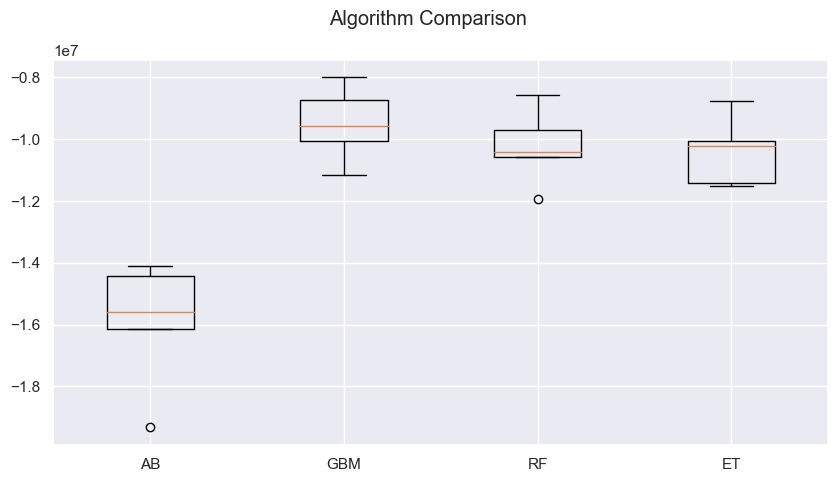

In [49]:
# boxplot comparison
fig = plt.figure()
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [50]:
# regression models, scaled data
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('Linear Reg', LinearRegression())])))
pipelines.append(('ScaledLasso', Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso())])))
pipelines.append(('ScaledLassoCV', Pipeline([('Scaler', StandardScaler()),('LassoCV', LassoCV())])))
pipelines.append(('ScaledRidgeCV', Pipeline([('Scaler', StandardScaler()),('RidgeCV', RidgeCV())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('Elastic Net', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -12429112.666045 (455774.767323)
ScaledLasso: -12429113.274045 (455775.413650)
ScaledLassoCV: -12525183.211332 (534992.241738)
ScaledRidgeCV: -12527743.199716 (529987.533027)
ScaledEN: -12280681.357947 (1013827.771958)
ScaledKNN: -10095704.154969 (924499.899942)


<Figure size 640x480 with 0 Axes>

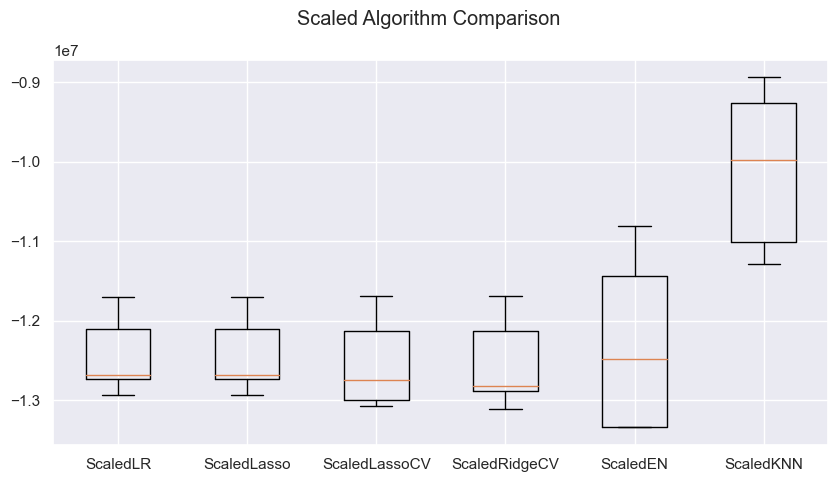

In [51]:
# boxplot comparison
fig = plt.figure()
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [52]:
# ensemble models, scaled data
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -16666124.084118 (1955421.146689)
ScaledGBM: -9467963.715391 (1050255.091379)
ScaledRF: -10617952.312445 (1369804.196005)
ScaledET: -10250316.838964 (1070118.823987)


<Figure size 640x480 with 0 Axes>

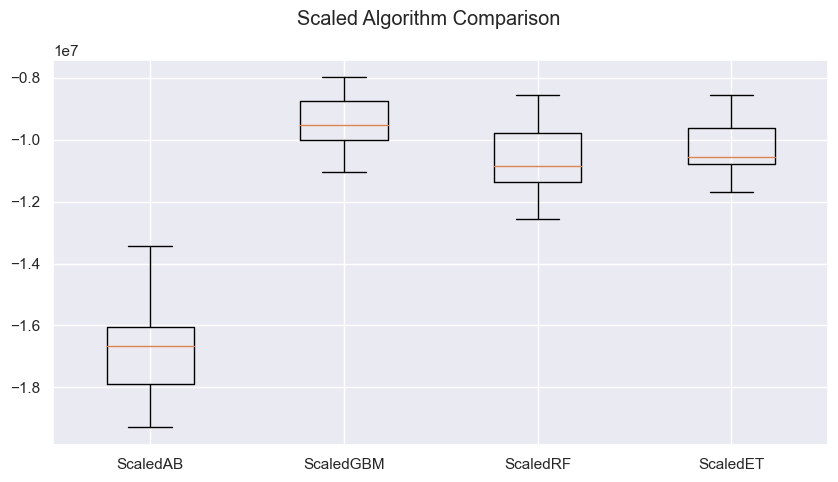

In [53]:
# boxplot comparison
fig = plt.figure()
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**END OF PART 3**